# Отток клиентов

**Цель проекта** — обучить на данных модель для прогноза оттока клиентов.

## Импорты и константы

In [1]:
RANDOM_STATE = 231023

In [2]:
!pip install phik

In [3]:
!pip install torchvision

In [4]:
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import time
from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier



import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Распаковка данных

In [5]:
db_config = {
            'user': 'praktikum_student', # Имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # Пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # Хост
            'port': 6432, # Порт подключения
            'db': 'data-science-final' # Название базы данных,
            }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string)

In [6]:
contract = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(contract, con = engine)
contract.name = 'contract'


In [7]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Наименования столбцов в порядке. В столбцах BeginDate и EndDate нужно сменить тип данных .

Рассмотрим пропуски в столбце TotalCharges.

In [9]:
contract.loc[contract.TotalCharges.isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


In [10]:
contract.loc[contract.TotalCharges.isna()]['BeginDate'].value_counts()

2020-02-01    11
Name: BeginDate, dtype: int64

Данные пропущенные значения связаны лишь с теми людьми, которые сформировали договор с «ТелеДом» в последний день сбора данных ("Информация о договорах актуальна на 1 февраля 2020"), никакой полезной информации они не предоставят, мы их удалим. 

In [11]:
personal = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(personal, con = engine)
personal.name = 'personal'

In [12]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В дальнейшем необходимо изменить данные в столбце SeniorCitizen (является ли абонент пенсионером) int -> object.

In [14]:
internet = '''
SELECT *
FROM telecom.internet
'''
internet = pd.read_sql_query(internet, con = engine)
internet_columns = internet.iloc[0]
internet = internet[1:]
internet.columns = internet_columns
internet.name = 'internet'

In [15]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропущенных значений нет, наименования столбцов в норме.

In [17]:
phone = '''
SELECT *
FROM telecom.phone
'''
phone = pd.read_sql_query(phone, con = engine)
phone_columns = phone.iloc[0]
phone = phone[1:]
phone.columns = phone_columns
phone.name = 'phone'

In [18]:
phone.head()

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [19]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пересечение множества значений customerID из столбца internet и phone даст нам 4835 значений - клиенты, которые пользуются и интернетом, и телефонной связью вместе. Это означает, что не все пользователи пользуются и тем, и тем сразу. Пересечение contract и internet даст нам 5517 значений, а contract и phone - 6361 значение. При дальнейшем объединении всех 4 таблиц нужно будет заполнять NaN значения определённым типом "Без интернета" или "Без телефонной связи".

### Вывод

Удалось установить связь с базой данных, получили 4 таблицы:

- contract — информация о договорах. Всего наблюдений по контрактам у нас 7043. В данном DF 73,5% пропущенных значений в признаке EndDate (дата окончания действия договора) - это пользователи, которые не разорвали контракт, наш будущий класс 0. А также 11 NaN значений в столбце TotalCharges (общие расходы абонента), данные пропущенные значения связаны лишь с теми людьми, которые сформировали договор с «ТелеДом» в последний день сбора данных ("Информация о договорах актуальна на 1 февраля 2020"), поэтому никакой полезной информации, к сожалению, они нам не предоставят, и мы их удалим. Наименования столбцов в порядке, однако необходимо поменять тип данных столбцов BeginDate и EndDate -> datetime[64].
- personal — персональные данные клиентов. В данном DF также 7043 наблюдений (1 пользователь - 1 контракт). В дальнейшем необходимо изменить данные в столбце SeniorCitizen (является ли абонент пенсионером) int -> object.
- internet — информация об интернет-услугах. Всего 5517 наблюдений. Пропущенных значений нет, наименования столбцов в норме.
- phone — информация об услугах телефонии. Он предоставляет нам 6361 наблюдение.

При дальнейшем объединении всех 4 таблиц нужно будет заполнять NaN значения определённым типом "Без интернета" или "Без телефонной связи", т.к. не у всех пользователей подключены и Интернет и телефонная связь вместе.

## Объединение данных

In [20]:
contract.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN


In [21]:
for column in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print(f'Количество уникальных значений столбца {column}: {contract[column].nunique()}')
    print(contract[column].unique())
    print('-----------------------------')

Количество уникальных значений столбца Type: 3
['Two year' 'Month-to-month' 'One year']
-----------------------------
Количество уникальных значений столбца PaperlessBilling: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца PaymentMethod: 4
['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
-----------------------------


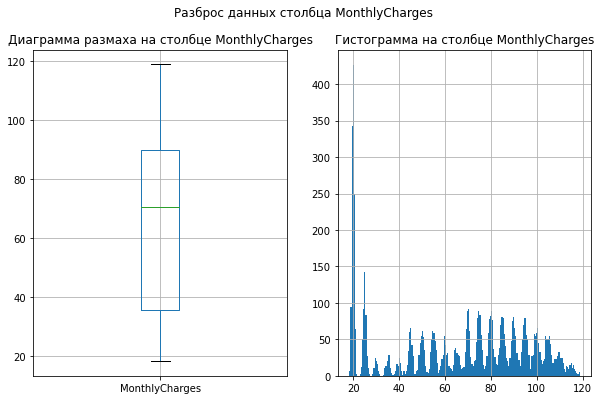

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
contract.boxplot(column='MonthlyCharges', ax=ax[0])
ax[0].set_title(f'Диаграмма размаха на столбце MonthlyCharges')
ax[0].grid(True)

ax[1].hist(contract['MonthlyCharges'], bins=200)
ax[1].set_title(f'Гистограмма на столбце MonthlyCharges')
ax[1].grid(True)

fig.suptitle(f'Разброс данных столбца MonthlyCharges')

plt.show()

MonthlyCharges имеет множество пиковых зон, видимо связанных с ежемесячным платежём, а разбросы рядом с ними - дополнительные затраты пользователей в месяц. Судя по boxplot, признак не имеет выбросов, а медиана находится в районе значения 70, при этом данные в большинстве своём находятся в диапазоне от 35 до 90 условных единиц.

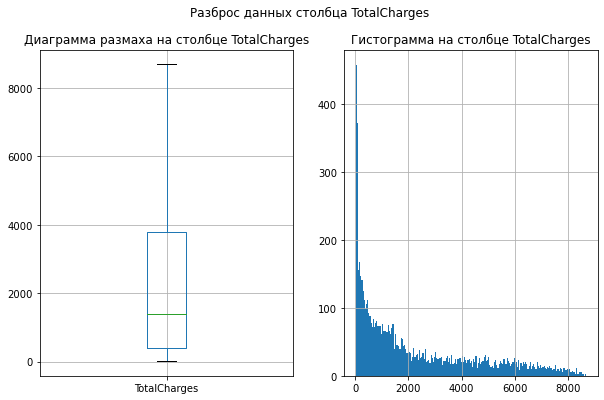

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
contract.boxplot(column='TotalCharges', ax=ax[0])
ax[0].set_title(f'Диаграмма размаха на столбце TotalCharges')
ax[0].grid(True)

ax[1].hist(contract['TotalCharges'], bins=200)
ax[1].set_title(f'Гистограмма на столбце TotalCharges')
ax[1].grid(True)

fig.suptitle(f'Разброс данных столбца TotalCharges')

plt.show()

TotalCharges имеет показательное распределение в диапазоне (0, 8600), плавно убывающее в сторону положительного oX. В данных также отсутствуют выбросы, медиана распределена в районе 1600, а большинство значений находятся в диапазоне от 300 до 3700. Подобное распределение обусловленно накопительным свойством клиента - чем дольше он с договором, тем больше суммарная цена затрат.

In [24]:
personal.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [25]:
for column in personal.columns.drop('customerID'):
    print(f'Количество уникальных значений столбца {column}: {personal[column].nunique()}')
    print(personal[column].unique())
    print('-----------------------------')

Количество уникальных значений столбца gender: 2
['Female' 'Male']
-----------------------------
Количество уникальных значений столбца SeniorCitizen: 2
[0 1]
-----------------------------
Количество уникальных значений столбца Partner: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца Dependents: 2
['No' 'Yes']
-----------------------------


In [26]:
internet.head(1)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [27]:
for column in internet.columns.drop('customerID'):
    print(f'Количество уникальных значений столбца {column}: {internet[column].nunique()}')
    print(internet[column].unique())
    print('-----------------------------')

Количество уникальных значений столбца InternetService: 2
['DSL' 'Fiber optic']
-----------------------------
Количество уникальных значений столбца OnlineSecurity: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца OnlineBackup: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца DeviceProtection: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца TechSupport: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingTV: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingMovies: 2
['No' 'Yes']
-----------------------------


In [28]:
phone.head(1)

,customerID,MultipleLines
1,5575-GNVDE,No


In [29]:
for column in phone.columns.drop('customerID'):
    print(f'Количество уникальных значений столбца {column}: {phone[column].nunique()}')
    print(phone[column].unique())
    print('-----------------------------')

Количество уникальных значений столбца MultipleLines: 2
['No' 'Yes']
-----------------------------


In [30]:
data = personal.merge(contract, on ='customerID', how='inner')
data = data.merge(internet, on ='customerID', how = 'outer')
data = data.merge(phone, on ='customerID', how = 'outer')
data.name = 'data'

In [31]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Неявных дубликатов в таблицах не обнаружили. После объединения всех 4 таблиц в один DF у нас получилось 20 столбцов, и 7043 наблюдения. 

На следующем этапе следует убрать NaN значения, которые появились из-за того, что не все пользователи пользуются и интернетом, и телефонной связью одновременно. Также стоит провести features engineering со столбцами datetime, тк свою полезность они маловероятно покажут на этапе предсказаний.

## Предобработка

Преобразуем столбец EndDate в целевую переменную.

In [33]:
def target_map(row):
    
    if row['EndDate'] is None:
        return 0
    return 1

data['target'] = data.progress_apply(target_map, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 7043/7043 [00:00<00:00, 67071.15it/s]


Заполним NaN значения, которые появились при объединении сущностей: WOI - без интернета, WOT - без телефонной связи.

In [34]:
woi = ['MultipleLines']
wot = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

data[woi] = data[woi].fillna('WOI')
data[wot] = data[wot].fillna('WOT')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Поменяем int на object в столбце SeniorCitizen.

In [35]:
data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

data.SeniorCitizen.unique()

array(['No', 'Yes'], dtype=object)

Попробуем сгенерировать новые признаки.

- use_days - количество дней пользования тарифом. Если контракт не разорван - ограничиваемся дедлайном.

In [36]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['EndDate'] = data['EndDate'].fillna(pd.to_datetime('01-02-2020', format='%d-%m-%Y'))
data['use_days'] = (data['EndDate'] - data['BeginDate']).dt.days

data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,use_days
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,2020-02-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,WOI,0,278
1,5575-GNVDE,Male,No,No,No,2019-03-26,2020-02-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,312
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,1,479


- dbp - количество дней, которые остались до оплаты пользования за следующий период.

In [37]:
def days_before_payment(row):
    if row['Type'] == 'Month-to-month':
        return row['use_days'] % 30
    elif row['Type'] == 'One year':
        return row['use_days'] % 366
    return row['use_days'] % 732

data['dbp'] = data.progress_apply(days_before_payment, axis=1)
data.head(3)

100%|███████████████████████████████████████████████████████████████████████████| 7043/7043 [00:00<00:00, 33219.17it/s]


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,use_days,dbp
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,2020-02-01,Month-to-month,Yes,Electronic check,...,No,Yes,No,No,No,No,WOI,0,278,8
1,5575-GNVDE,Male,No,No,No,2019-03-26,2020-02-01,One year,No,Mailed check,...,Yes,No,Yes,No,No,No,No,0,312,312
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,Yes,Yes,No,No,No,No,No,1,479,29


Удалим столбцы времени и оставшиеся 11 NaN значений.

In [38]:
del data['BeginDate']
del data['EndDate'] 
del data['customerID']

data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   Type              7032 non-null   object 
 5   PaperlessBilling  7032 non-null   object 
 6   PaymentMethod     7032 non-null   object 
 7   MonthlyCharges    7032 non-null   float64
 8   TotalCharges      7032 non-null   float64
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 


In [39]:
data.duplicated().sum()

0

In [40]:
data['target'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: target, dtype: float64

Обнаружен дисбаланс классов 73%/27%, что в дальнейшей работе будем исправлять весами модели (class_weight='balanced). 

## Исследовательский анализ данных

In [41]:
phik_overview = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'use_days', 'dbp'])
phik_overview.round(2)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,use_days,dbp
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
SeniorCitizen,0.00,1.00,0.02,0.32,0.09,0.24,0.29,0.30,0.15,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.23,0.04,0.17
Partner,0.00,0.02,1.00,0.65,0.18,0.01,0.24,0.20,0.42,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.23,0.00,0.35
Dependents,0.00,0.32,0.65,1.00,0.15,0.17,0.22,0.18,0.12,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.01,0.25,0.00,0.29
Type,0.00,0.09,0.18,0.15,1.00,0.11,0.28,0.39,0.51,0.50,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.25,0.00,0.80
PaperlessBilling,0.00,0.24,0.01,0.17,0.11,1.00,0.37,0.47,0.21,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.30,0.04,0.22
PaymentMethod,0.00,0.29,0.24,0.22,0.28,0.37,1.00,0.40,0.35,0.32,0.31,0.29,0.30,0.32,0.28,0.28,0.17,0.45,0.00,0.33
MonthlyCharges,0.01,0.30,0.20,0.18,0.39,0.47,0.40,1.00,0.76,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.36,0.00,0.33
TotalCharges,0.00,0.15,0.42,0.12,0.51,0.21,0.35,0.76,1.00,0.51,0.53,0.57,0.57,0.54,0.57,0.57,0.49,0.28,0.02,0.45
InternetService,0.00,0.16,0.00,0.11,0.50,0.23,0.32,0.92,0.51,1.00,0.95,0.94,0.94,0.95,0.95,0.95,0.74,0.20,0.00,0.30


In [42]:
def violentplot(df, column, target):
    plt.figure(figsize = (8, 5))
    sns.violinplot(
        x = target,
        y = column,
        data = df,
        kind = "violin",
        split = True,
        palette = "coolwarm"
    )
    plt.show()

    if df[column].nunique() <= 25:
        plt.figure(figsize = (12, 10))
        sns.histplot(data=df,
                     x=column,
                     binwidth=1,
                     hue=target)
        plt.show()

    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()

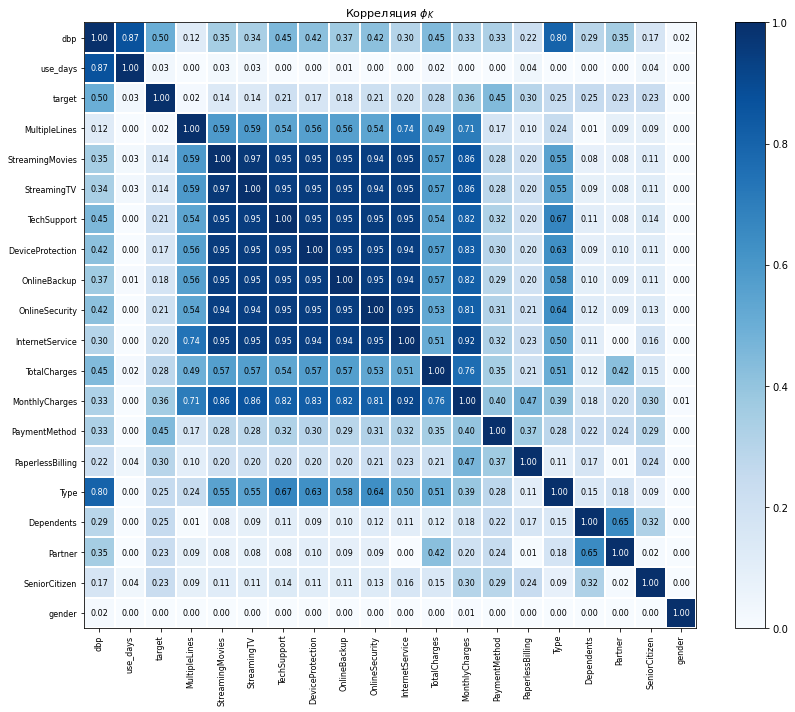

In [43]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

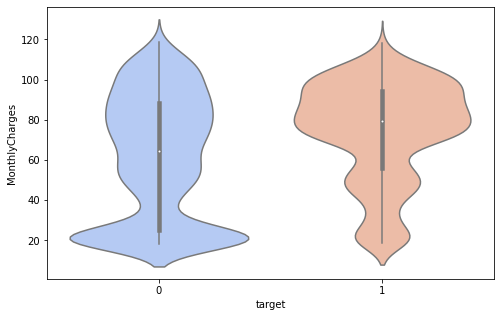


Корреляция Phik: 0.36
-----------------------------------------------------------------------------------------------



In [44]:
violentplot(data, 'MonthlyCharges', 'target')

Мы можем наблюдать, что клиент чаще всего уходит при больших ежемесячных затратах. Большинство людей, которые не разорвали договор с компанией платят 20 условных денежных единиц, но как только планка поднимается до 80 - шанс расторжения договора повышается. У данного признака слабая зависимость с нашей целевой переменной.

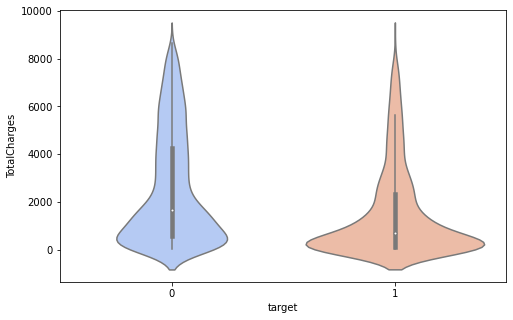


Корреляция Phik: 0.28
-----------------------------------------------------------------------------------------------



In [45]:
violentplot(data, 'TotalCharges', 'target')

Данная взаимосвязь может говорить о том, что человек уходит от компании буквально на первых этапах знакомства с тарифом. Также можно заметить, что "долгие контракты" чаще всего остаются в компании. Если тариф полностью покрывает необходимости клиента - он им пользуется на протяжении долгого времени. Наблюдается слабая зависимость равная 28%.

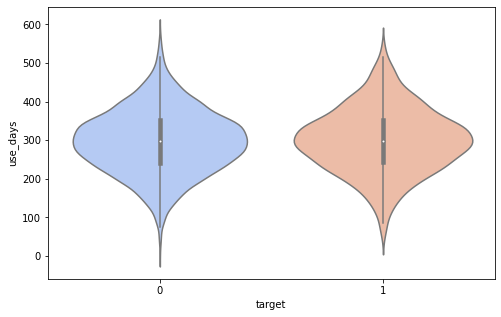


Корреляция Phik: 0.03
-----------------------------------------------------------------------------------------------



In [46]:
violentplot(data, 'use_days', 'target')

Данные нового добавленного столбца независимы между собой. 

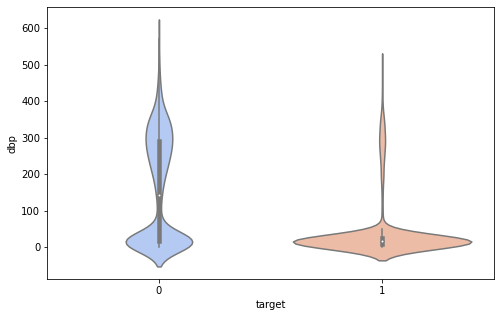


Корреляция Phik: 0.5
-----------------------------------------------------------------------------------------------



In [47]:
violentplot(data, 'dbp', 'target')

Признак dbp - количество дней, которые остались до оплаты следующего периода тарифа. Достаточно хороший показатель, который имеет умеренную зависимость. Пользователи чаще всего отказываются от тарифа в последние дни.

In [48]:
def proba_plot(data, column):
    array0 = []
    array1 = []
    unique_list = list(data[column].unique())
    for i in range(len(unique_list)):
        all_unique = data.loc[data[column] == unique_list[i], column].count()

        target_1 = data.loc[(data[column] == unique_list[i]) & (data['target'] == 1), column].count()
        proba1 = np.round((target_1 / all_unique), 2)
        target_0 = data.loc[(data[column] == unique_list[i]) & (data['target'] == 0), column].count()
        proba0 = np.round((target_0 / all_unique), 2)

        array0.append([unique_list[i], proba0, 'Не ушёл'])
        array1.append([unique_list[i], proba1, 'Ушёл'])

    array = np.concatenate([array0, array1], axis=0)
    df = pd.DataFrame(data=array, columns = ['Уникальные значения столбца '+column, 'Доля клиентов', 'Hue'])
    df['Доля клиентов'] = df['Доля клиентов'].astype(float)
    display(df)
    
    sns.barplot(data = df, x = 'Уникальные значения столбца '+column, y = 'Доля клиентов', hue = 'Hue')
    plt.show()
    
    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()
    
    return None

,Уникальные значения столбца gender,Доля клиентов,Hue
0,Female,0.73,Не ушёл
1,Male,0.74,Не ушёл
2,Female,0.27,Ушёл
3,Male,0.26,Ушёл


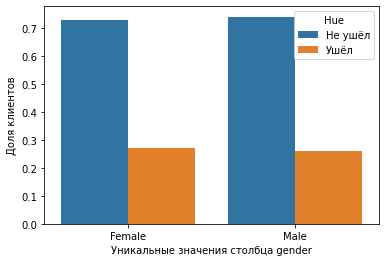


Корреляция Phik: 0.0
-----------------------------------------------------------------------------------------------



In [49]:
proba_plot(data, 'gender')

Признак пола независим с нашим таргетом.

,Уникальные значения столбца Type,Доля клиентов,Hue
0,Month-to-month,0.57,Не ушёл
1,One year,0.89,Не ушёл
2,Two year,0.97,Не ушёл
3,Month-to-month,0.43,Ушёл
4,One year,0.11,Ушёл
5,Two year,0.03,Ушёл


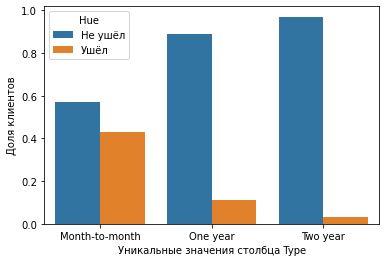


Корреляция Phik: 0.25
-----------------------------------------------------------------------------------------------



In [50]:
proba_plot(data, 'Type')

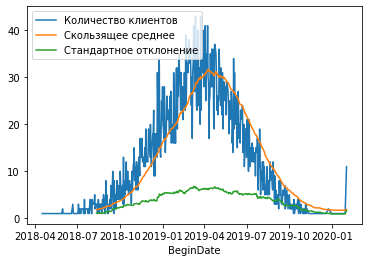

In [51]:
begin_pivot = contract.pivot_table(index='BeginDate', values='customerID', aggfunc='count')

begin_pivot['Скользящее среднее'] = begin_pivot['customerID'].rolling(50).mean()
begin_pivot['Стандартное отклонение'] = begin_pivot['customerID'].rolling(50).std()
begin_pivot.rename(columns={'customerID': 'Количество клиентов'}, inplace=True)
begin_pivot.plot()
plt.show()

Чаще всего контракт разрывают клиенты, которые платят за тариф раз в месяц. Если человек будет платить раз в год-два, то с большей вероятностью он не будет разрывать контракт, тк уверен в своём выборе. 

Однако, скорее всего, здесь работает немного другая логика - пользователь чаще всего разрывает контракт на последних месяцах пользования, а в выборке самый "первый" клиент имеет временную метку datetime.date(2018, 4, 17), тогда мы не можем утверждать, что данный признак является актуальным для нас, ведь пик подписания контрактов - май 2019 года, а информация о договорах актуальна на 1 февраля 2020. Нам придётся отказаться от данного признака, тк он не объективен для наших данных. При будущих предсказаниях в компании алгоритм может с бОльшей вероятностью выдавать класс 0, если человек платит раз в год-два, хотя это скорее всего не так. 

,Уникальные значения столбца SeniorCitizen,Доля клиентов,Hue
0,No,0.76,Не ушёл
1,Yes,0.58,Не ушёл
2,No,0.24,Ушёл
3,Yes,0.42,Ушёл


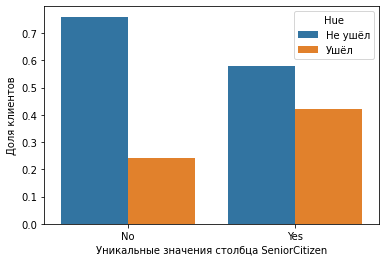


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------



In [52]:
proba_plot(data, 'SeniorCitizen')

Пенсионеры чаще разрывают договоры, нежели остальные. Данный столбец имеет 23% слабую зависимость.

,Уникальные значения столбца Partner,Доля клиентов,Hue
0,Yes,0.80,Не ушёл
1,No,0.67,Не ушёл
2,Yes,0.20,Ушёл
3,No,0.33,Ушёл


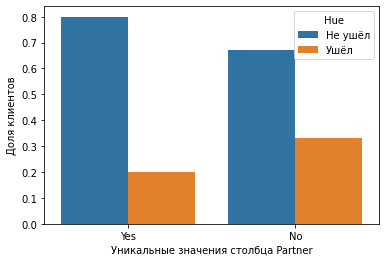


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------



In [53]:
proba_plot(data, 'Partner')

Неженатые люди чаще всего уходят от компании, тем не менее мы имеет слабую зависимость равную 23%.

,Уникальные значения столбца Dependents,Доля клиентов,Hue
0,No,0.69,Не ушёл
1,Yes,0.84,Не ушёл
2,No,0.31,Ушёл
3,Yes,0.16,Ушёл


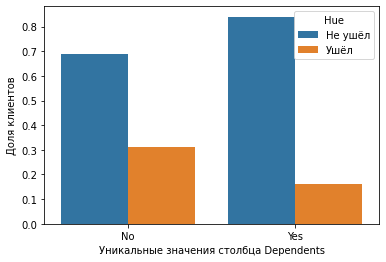


Корреляция Phik: 0.25
-----------------------------------------------------------------------------------------------



In [54]:
proba_plot(data, 'Dependents')

Чаще всего люди с детьми разрывают договор с компанией. Мы имеем слабую зависимость в 25%

,Уникальные значения столбца PaperlessBilling,Доля клиентов,Hue
0,Yes,0.66,Не ушёл
1,No,0.84,Не ушёл
2,Yes,0.34,Ушёл
3,No,0.16,Ушёл


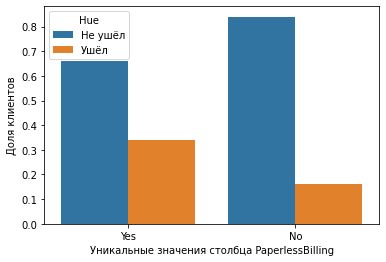


Корреляция Phik: 0.3
-----------------------------------------------------------------------------------------------



In [55]:
proba_plot(data, 'PaperlessBilling')

,Уникальные значения столбца PaymentMethod,Доля клиентов,Hue
0,Electronic check,0.55,Не ушёл
1,Mailed check,0.81,Не ушёл
2,Bank transfer (automatic),0.83,Не ушёл
3,Credit card (automatic),0.85,Не ушёл
4,Electronic check,0.45,Ушёл
5,Mailed check,0.19,Ушёл
6,Bank transfer (automatic),0.17,Ушёл
7,Credit card (automatic),0.15,Ушёл


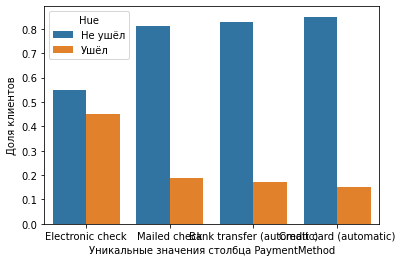


Корреляция Phik: 0.45
-----------------------------------------------------------------------------------------------



In [56]:
proba_plot(data, 'PaymentMethod')

Клиенты, которые пользуются любым видом автоплатежа из представленных с меньшей вероятностью разорвут договор с компанией, в отличии от тех, кто пользуется электронным чеком. 

,Уникальные значения столбца InternetService,Доля клиентов,Hue
0,DSL,0.81,Не ушёл
1,Fiber optic,0.58,Не ушёл
2,WOT,0.93,Не ушёл
3,DSL,0.19,Ушёл
4,Fiber optic,0.42,Ушёл
5,WOT,0.07,Ушёл


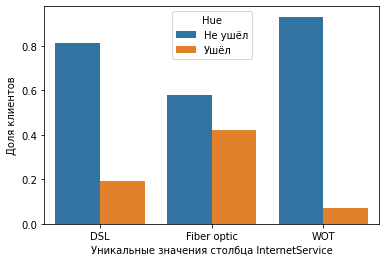


Корреляция Phik: 0.2
-----------------------------------------------------------------------------------------------



In [57]:
proba_plot(data, 'InternetService')

Мы можем наблюдать слабую корреляцию между признаком InternetService и нашей целевой переменой, однако люди, которые выбирают оптоволокно чаще всего отказываются от услуг компании. 

,Уникальные значения столбца OnlineSecurity,Доля клиентов,Hue
0,No,0.58,Не ушёл
1,Yes,0.85,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.42,Ушёл
4,Yes,0.15,Ушёл
5,WOT,0.07,Ушёл


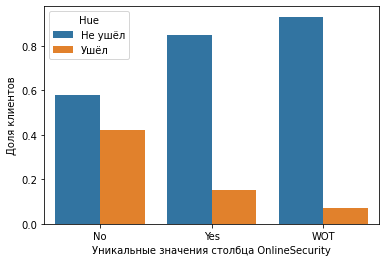


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------



In [58]:
proba_plot(data, 'OnlineSecurity')

Доля клиентов без блокировки опасных сайтов, которые отказались от услуг провайдера превышет обратную. Зависимость равна 21 %

,Уникальные значения столбца OnlineBackup,Доля клиентов,Hue
0,Yes,0.78,Не ушёл
1,No,0.60,Не ушёл
2,WOT,0.93,Не ушёл
3,Yes,0.22,Ушёл
4,No,0.40,Ушёл
5,WOT,0.07,Ушёл


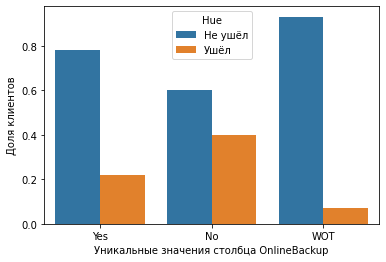


Корреляция Phik: 0.18
-----------------------------------------------------------------------------------------------



In [59]:
proba_plot(data, 'OnlineBackup')

Клиенты, которые пользуются облачными хранилищами файлов для резервного копирования данных реже разрывают контракт, нежели те, кто не пользуются. Наблюдается слабая зависимость равная 18%.

,Уникальные значения столбца DeviceProtection,Доля клиентов,Hue
0,No,0.61,Не ушёл
1,Yes,0.77,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.39,Ушёл
4,Yes,0.23,Ушёл
5,WOT,0.07,Ушёл


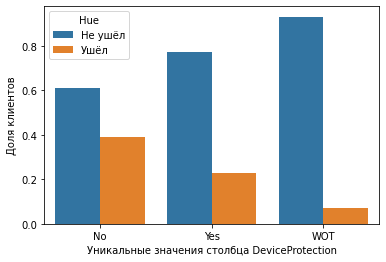


Корреляция Phik: 0.17
-----------------------------------------------------------------------------------------------



In [60]:
proba_plot(data, 'DeviceProtection')

Схожая картина с признаком Online Security наблюдается на Device Protection. Слабая зависимость в 17%.

,Уникальные значения столбца TechSupport,Доля клиентов,Hue
0,No,0.58,Не ушёл
1,Yes,0.85,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.42,Ушёл
4,Yes,0.15,Ушёл
5,WOT,0.07,Ушёл


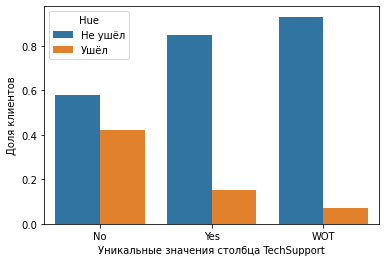


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------



In [61]:
proba_plot(data, 'TechSupport')

Люди без выделенной линии технической поддержки чаще всего уходят из компании. Наблюдается слабая зависимость равная 21%

,Уникальные значения столбца StreamingTV,Доля клиентов,Hue
0,No,0.66,Не ушёл
1,Yes,0.70,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.34,Ушёл
4,Yes,0.30,Ушёл
5,WOT,0.07,Ушёл


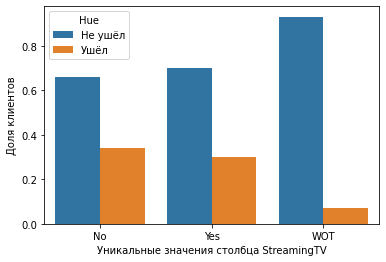


Корреляция Phik: 0.14
-----------------------------------------------------------------------------------------------



In [62]:
proba_plot(data, 'StreamingTV')

,Уникальные значения столбца StreamingMovies,Доля клиентов,Hue
0,No,0.66,Не ушёл
1,Yes,0.70,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.34,Ушёл
4,Yes,0.30,Ушёл
5,WOT,0.07,Ушёл


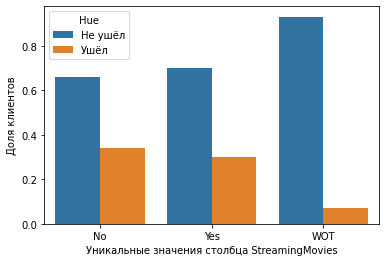


Корреляция Phik: 0.14
-----------------------------------------------------------------------------------------------



In [63]:
proba_plot(data, 'StreamingMovies')

Судя по графику данные независимы между собой. 

,Уникальные значения столбца MultipleLines,Доля клиентов,Hue
0,WOI,0.75,Не ушёл
1,No,0.75,Не ушёл
2,Yes,0.71,Не ушёл
3,WOI,0.25,Ушёл
4,No,0.25,Ушёл
5,Yes,0.29,Ушёл


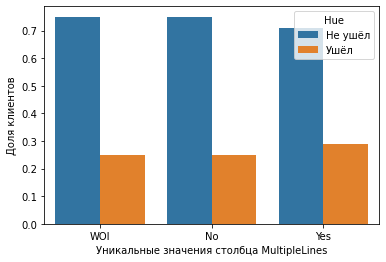


Корреляция Phik: 0.02
-----------------------------------------------------------------------------------------------



In [64]:
proba_plot(data, 'MultipleLines')

Признак подключения телефона к нескольким линиям одновременно независим с нашим таргетом. 

Мы имеет 3 сильных признака, которые не имеют мультикорреляцию. Остальные оставим - они необходимы для прироста информации.

In [65]:
for column in ['use_days', 'gender', 'Type']:
    del data[column]

## Выбор модели

### Подготовка данных

In [66]:
features = data.drop('target', axis=1)
target = data['target']

In [67]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size = .25,
                                                                            random_state = RANDOM_STATE)


print(features_train.shape, target_train.shape,
      features_test.shape, target_test.shape)

(5274, 16) (5274,) (1758, 16) (1758,)


In [68]:
numerics = list(features.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(features.select_dtypes(include='object').columns)

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(features_train)
features_train = col_transformer.transform(features_train)
features_test = col_transformer.transform(features_test)

In [69]:
names = ['features_train', 'features_test']
ds = [features_train, features_test]
for i in range(len(ds)):
    print('-'*50)
    print(f'Размернoсть {names[i]}:', ds[i].shape)
    print()

--------------------------------------------------
Размернoсть features_train: (5274, 26)

--------------------------------------------------
Размернoсть features_test: (1758, 26)



### RandomForestClassifier

In [70]:
analitics = pd.DataFrame(columns = ['ROC_AUC', 'Precision'])

def alter_table(name, roc_auc, precision):
    analitics.loc[name, ['ROC_AUC']] = roc_auc
    analitics.loc[name, ['Precision']] = precision
    return analitics

In [71]:
grid_params = {
    'n_estimators': np.arange(40, 100, 10),
    'max_depth' : np.arange(12, 24)
}

grid_rf = GridSearchCV(RandomForestClassifier(), grid_params, cv=3, verbose=10, scoring=['roc_auc', 'precision'], refit = 'roc_auc').fit(features_train, target_train)
best_rf = grid_rf.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3; 1/72] START max_depth=12, n_estimators=40..............................
[CV 1/3; 1/72] END max_depth=12, n_estimators=40; precision: (test=0.641) roc_auc: (test=0.824) total time=   0.1s
[CV 2/3; 1/72] START max_depth=12, n_estimators=40..............................
[CV 2/3; 1/72] END max_depth=12, n_estimators=40; precision: (test=0.590) roc_auc: (test=0.817) total time=   0.1s
[CV 3/3; 1/72] START max_depth=12, n_estimators=40..............................
[CV 3/3; 1/72] END max_depth=12, n_estimators=40; precision: (test=0.644) roc_auc: (test=0.827) total time=   0.1s
[CV 1/3; 2/72] START max_depth=12, n_estimators=50..............................
[CV 1/3; 2/72] END max_depth=12, n_estimators=50; precision: (test=0.623) roc_auc: (test=0.828) total time=   0.2s
[CV 2/3; 2/72] START max_depth=12, n_estimators=50..............................
[CV 2/3; 2/72] END max_depth=12, n_estimators=50; precision: (test=0.619)

[CV 3/3; 14/72] END max_depth=14, n_estimators=50; precision: (test=0.632) roc_auc: (test=0.822) total time=   0.2s
[CV 1/3; 15/72] START max_depth=14, n_estimators=60.............................
[CV 1/3; 15/72] END max_depth=14, n_estimators=60; precision: (test=0.634) roc_auc: (test=0.823) total time=   0.2s
[CV 2/3; 15/72] START max_depth=14, n_estimators=60.............................
[CV 2/3; 15/72] END max_depth=14, n_estimators=60; precision: (test=0.611) roc_auc: (test=0.819) total time=   0.2s
[CV 3/3; 15/72] START max_depth=14, n_estimators=60.............................
[CV 3/3; 15/72] END max_depth=14, n_estimators=60; precision: (test=0.624) roc_auc: (test=0.825) total time=   0.3s
[CV 1/3; 16/72] START max_depth=14, n_estimators=70.............................
[CV 1/3; 16/72] END max_depth=14, n_estimators=70; precision: (test=0.622) roc_auc: (test=0.817) total time=   0.3s
[CV 2/3; 16/72] START max_depth=14, n_estimators=70.............................
[CV 2/3; 16/72]

[CV 3/3; 28/72] END max_depth=16, n_estimators=70; precision: (test=0.632) roc_auc: (test=0.824) total time=   0.3s
[CV 1/3; 29/72] START max_depth=16, n_estimators=80.............................
[CV 1/3; 29/72] END max_depth=16, n_estimators=80; precision: (test=0.633) roc_auc: (test=0.819) total time=   0.3s
[CV 2/3; 29/72] START max_depth=16, n_estimators=80.............................
[CV 2/3; 29/72] END max_depth=16, n_estimators=80; precision: (test=0.599) roc_auc: (test=0.815) total time=   0.3s
[CV 3/3; 29/72] START max_depth=16, n_estimators=80.............................
[CV 3/3; 29/72] END max_depth=16, n_estimators=80; precision: (test=0.639) roc_auc: (test=0.825) total time=   0.3s
[CV 1/3; 30/72] START max_depth=16, n_estimators=90.............................
[CV 1/3; 30/72] END max_depth=16, n_estimators=90; precision: (test=0.623) roc_auc: (test=0.820) total time=   0.4s
[CV 2/3; 30/72] START max_depth=16, n_estimators=90.............................
[CV 2/3; 30/72]

[CV 3/3; 42/72] END max_depth=18, n_estimators=90; precision: (test=0.636) roc_auc: (test=0.822) total time=   0.5s
[CV 1/3; 43/72] START max_depth=19, n_estimators=40.............................
[CV 1/3; 43/72] END max_depth=19, n_estimators=40; precision: (test=0.610) roc_auc: (test=0.813) total time=   0.2s
[CV 2/3; 43/72] START max_depth=19, n_estimators=40.............................
[CV 2/3; 43/72] END max_depth=19, n_estimators=40; precision: (test=0.620) roc_auc: (test=0.811) total time=   0.2s
[CV 3/3; 43/72] START max_depth=19, n_estimators=40.............................
[CV 3/3; 43/72] END max_depth=19, n_estimators=40; precision: (test=0.644) roc_auc: (test=0.813) total time=   0.2s
[CV 1/3; 44/72] START max_depth=19, n_estimators=50.............................
[CV 1/3; 44/72] END max_depth=19, n_estimators=50; precision: (test=0.618) roc_auc: (test=0.814) total time=   0.2s
[CV 2/3; 44/72] START max_depth=19, n_estimators=50.............................
[CV 2/3; 44/72]

[CV 3/3; 56/72] END max_depth=21, n_estimators=50; precision: (test=0.623) roc_auc: (test=0.820) total time=   0.3s
[CV 1/3; 57/72] START max_depth=21, n_estimators=60.............................
[CV 1/3; 57/72] END max_depth=21, n_estimators=60; precision: (test=0.619) roc_auc: (test=0.816) total time=   0.2s
[CV 2/3; 57/72] START max_depth=21, n_estimators=60.............................
[CV 2/3; 57/72] END max_depth=21, n_estimators=60; precision: (test=0.602) roc_auc: (test=0.812) total time=   0.3s
[CV 3/3; 57/72] START max_depth=21, n_estimators=60.............................
[CV 3/3; 57/72] END max_depth=21, n_estimators=60; precision: (test=0.647) roc_auc: (test=0.824) total time=   0.3s
[CV 1/3; 58/72] START max_depth=21, n_estimators=70.............................
[CV 1/3; 58/72] END max_depth=21, n_estimators=70; precision: (test=0.625) roc_auc: (test=0.815) total time=   0.4s
[CV 2/3; 58/72] START max_depth=21, n_estimators=70.............................
[CV 2/3; 58/72]

[CV 3/3; 70/72] END max_depth=23, n_estimators=70; precision: (test=0.646) roc_auc: (test=0.822) total time=   0.4s
[CV 1/3; 71/72] START max_depth=23, n_estimators=80.............................
[CV 1/3; 71/72] END max_depth=23, n_estimators=80; precision: (test=0.612) roc_auc: (test=0.813) total time=   0.5s
[CV 2/3; 71/72] START max_depth=23, n_estimators=80.............................
[CV 2/3; 71/72] END max_depth=23, n_estimators=80; precision: (test=0.601) roc_auc: (test=0.812) total time=   0.4s
[CV 3/3; 71/72] START max_depth=23, n_estimators=80.............................
[CV 3/3; 71/72] END max_depth=23, n_estimators=80; precision: (test=0.639) roc_auc: (test=0.822) total time=   0.4s
[CV 1/3; 72/72] START max_depth=23, n_estimators=90.............................
[CV 1/3; 72/72] END max_depth=23, n_estimators=90; precision: (test=0.629) roc_auc: (test=0.819) total time=   0.5s
[CV 2/3; 72/72] START max_depth=23, n_estimators=90.............................
[CV 2/3; 72/72]

In [72]:
cv_results = pd.DataFrame.from_dict(grid_rf.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('RandomForestClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
RandomForestClassifier,0.8279,0.634


### CatBoostClassifier

In [73]:
model_cbr = CatBoostClassifier(logging_level='Silent', loss_function='Logloss')
parameters_cbr = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1],
                  'iterations': [500,1000,1500,2000]}
catboost_grid = GridSearchCV(model_cbr,
                             parameters_cbr,
                             cv=3,
                             verbose=10,
                             scoring=['roc_auc', 'precision'],
                             refit = 'roc_auc').fit(features_train, target_train)

Fitting 3 folds for each of 140 candidates, totalling 420 fits
[CV 1/3; 1/140] START iterations=500, learning_rate=0.0001, max_depth=4.........
[CV 1/3; 1/140] END iterations=500, learning_rate=0.0001, max_depth=4; precision: (test=0.693) roc_auc: (test=0.835) total time=   2.3s
[CV 2/3; 1/140] START iterations=500, learning_rate=0.0001, max_depth=4.........
[CV 2/3; 1/140] END iterations=500, learning_rate=0.0001, max_depth=4; precision: (test=0.662) roc_auc: (test=0.822) total time=   2.0s
[CV 3/3; 1/140] START iterations=500, learning_rate=0.0001, max_depth=4.........
[CV 3/3; 1/140] END iterations=500, learning_rate=0.0001, max_depth=4; precision: (test=0.712) roc_auc: (test=0.830) total time=   2.1s
[CV 1/3; 2/140] START iterations=500, learning_rate=0.0001, max_depth=5.........
[CV 1/3; 2/140] END iterations=500, learning_rate=0.0001, max_depth=5; precision: (test=0.686) roc_auc: (test=0.837) total time=   5.1s
[CV 2/3; 2/140] START iterations=500, learning_rate=0.0001, max_depth

[CV 3/3; 13/140] END iterations=500, learning_rate=0.001, max_depth=9; precision: (test=0.678) roc_auc: (test=0.841) total time=   8.1s
[CV 1/3; 14/140] START iterations=500, learning_rate=0.001, max_depth=10........
[CV 1/3; 14/140] END iterations=500, learning_rate=0.001, max_depth=10; precision: (test=0.671) roc_auc: (test=0.847) total time=  10.7s
[CV 2/3; 14/140] START iterations=500, learning_rate=0.001, max_depth=10........
[CV 2/3; 14/140] END iterations=500, learning_rate=0.001, max_depth=10; precision: (test=0.675) roc_auc: (test=0.832) total time=  10.7s
[CV 3/3; 14/140] START iterations=500, learning_rate=0.001, max_depth=10........
[CV 3/3; 14/140] END iterations=500, learning_rate=0.001, max_depth=10; precision: (test=0.681) roc_auc: (test=0.841) total time=  10.9s
[CV 1/3; 15/140] START iterations=500, learning_rate=0.01, max_depth=4..........
[CV 1/3; 15/140] END iterations=500, learning_rate=0.01, max_depth=4; precision: (test=0.673) roc_auc: (test=0.850) total time=  

[CV 2/3; 26/140] END iterations=500, learning_rate=0.1, max_depth=8; precision: (test=0.594) roc_auc: (test=0.813) total time=   6.0s
[CV 3/3; 26/140] START iterations=500, learning_rate=0.1, max_depth=8...........
[CV 3/3; 26/140] END iterations=500, learning_rate=0.1, max_depth=8; precision: (test=0.630) roc_auc: (test=0.815) total time=   6.5s
[CV 1/3; 27/140] START iterations=500, learning_rate=0.1, max_depth=9...........
[CV 1/3; 27/140] END iterations=500, learning_rate=0.1, max_depth=9; precision: (test=0.592) roc_auc: (test=0.804) total time=   8.7s
[CV 2/3; 27/140] START iterations=500, learning_rate=0.1, max_depth=9...........
[CV 2/3; 27/140] END iterations=500, learning_rate=0.1, max_depth=9; precision: (test=0.586) roc_auc: (test=0.807) total time=   9.8s
[CV 3/3; 27/140] START iterations=500, learning_rate=0.1, max_depth=9...........
[CV 3/3; 27/140] END iterations=500, learning_rate=0.1, max_depth=9; precision: (test=0.621) roc_auc: (test=0.819) total time=   9.6s
[CV 1/

[CV 2/3; 39/140] END iterations=1000, learning_rate=0.0001, max_depth=7; precision: (test=0.672) roc_auc: (test=0.829) total time=   8.3s
[CV 3/3; 39/140] START iterations=1000, learning_rate=0.0001, max_depth=7.......
[CV 3/3; 39/140] END iterations=1000, learning_rate=0.0001, max_depth=7; precision: (test=0.692) roc_auc: (test=0.838) total time=   8.6s
[CV 1/3; 40/140] START iterations=1000, learning_rate=0.0001, max_depth=8.......
[CV 1/3; 40/140] END iterations=1000, learning_rate=0.0001, max_depth=8; precision: (test=0.683) roc_auc: (test=0.845) total time=  10.3s
[CV 2/3; 40/140] START iterations=1000, learning_rate=0.0001, max_depth=8.......
[CV 2/3; 40/140] END iterations=1000, learning_rate=0.0001, max_depth=8; precision: (test=0.682) roc_auc: (test=0.830) total time=  13.7s
[CV 3/3; 40/140] START iterations=1000, learning_rate=0.0001, max_depth=8.......
[CV 3/3; 40/140] END iterations=1000, learning_rate=0.0001, max_depth=8; precision: (test=0.686) roc_auc: (test=0.839) total

[CV 1/3; 52/140] END iterations=1000, learning_rate=0.01, max_depth=6; precision: (test=0.655) roc_auc: (test=0.840) total time=   8.8s
[CV 2/3; 52/140] START iterations=1000, learning_rate=0.01, max_depth=6.........
[CV 2/3; 52/140] END iterations=1000, learning_rate=0.01, max_depth=6; precision: (test=0.673) roc_auc: (test=0.833) total time=   8.5s
[CV 3/3; 52/140] START iterations=1000, learning_rate=0.01, max_depth=6.........
[CV 3/3; 52/140] END iterations=1000, learning_rate=0.01, max_depth=6; precision: (test=0.660) roc_auc: (test=0.844) total time=   9.0s
[CV 1/3; 53/140] START iterations=1000, learning_rate=0.01, max_depth=7.........
[CV 1/3; 53/140] END iterations=1000, learning_rate=0.01, max_depth=7; precision: (test=0.646) roc_auc: (test=0.837) total time=  10.8s
[CV 2/3; 53/140] START iterations=1000, learning_rate=0.01, max_depth=7.........
[CV 2/3; 53/140] END iterations=1000, learning_rate=0.01, max_depth=7; precision: (test=0.668) roc_auc: (test=0.832) total time=  11

[CV 3/3; 64/140] END iterations=1000, learning_rate=1, max_depth=4; precision: (test=0.527) roc_auc: (test=0.770) total time=   3.6s
[CV 1/3; 65/140] START iterations=1000, learning_rate=1, max_depth=5............
[CV 1/3; 65/140] END iterations=1000, learning_rate=1, max_depth=5; precision: (test=0.547) roc_auc: (test=0.764) total time=   6.2s
[CV 2/3; 65/140] START iterations=1000, learning_rate=1, max_depth=5............
[CV 2/3; 65/140] END iterations=1000, learning_rate=1, max_depth=5; precision: (test=0.537) roc_auc: (test=0.771) total time=   6.5s
[CV 3/3; 65/140] START iterations=1000, learning_rate=1, max_depth=5............
[CV 3/3; 65/140] END iterations=1000, learning_rate=1, max_depth=5; precision: (test=0.538) roc_auc: (test=0.771) total time=   7.1s
[CV 1/3; 66/140] START iterations=1000, learning_rate=1, max_depth=6............
[CV 1/3; 66/140] END iterations=1000, learning_rate=1, max_depth=6; precision: (test=0.561) roc_auc: (test=0.767) total time=   8.7s
[CV 2/3; 66

[CV 2/3; 77/140] END iterations=1500, learning_rate=0.0001, max_depth=10; precision: (test=0.687) roc_auc: (test=0.831) total time=  35.1s
[CV 3/3; 77/140] START iterations=1500, learning_rate=0.0001, max_depth=10......
[CV 3/3; 77/140] END iterations=1500, learning_rate=0.0001, max_depth=10; precision: (test=0.682) roc_auc: (test=0.840) total time=  35.3s
[CV 1/3; 78/140] START iterations=1500, learning_rate=0.001, max_depth=4........
[CV 1/3; 78/140] END iterations=1500, learning_rate=0.001, max_depth=4; precision: (test=0.695) roc_auc: (test=0.849) total time=   9.0s
[CV 2/3; 78/140] START iterations=1500, learning_rate=0.001, max_depth=4........
[CV 2/3; 78/140] END iterations=1500, learning_rate=0.001, max_depth=4; precision: (test=0.679) roc_auc: (test=0.831) total time=   8.7s
[CV 3/3; 78/140] START iterations=1500, learning_rate=0.001, max_depth=4........
[CV 3/3; 78/140] END iterations=1500, learning_rate=0.001, max_depth=4; precision: (test=0.682) roc_auc: (test=0.842) total 

[CV 1/3; 90/140] END iterations=1500, learning_rate=0.01, max_depth=9; precision: (test=0.629) roc_auc: (test=0.827) total time=  39.4s
[CV 2/3; 90/140] START iterations=1500, learning_rate=0.01, max_depth=9.........
[CV 2/3; 90/140] END iterations=1500, learning_rate=0.01, max_depth=9; precision: (test=0.644) roc_auc: (test=0.825) total time=  38.2s
[CV 3/3; 90/140] START iterations=1500, learning_rate=0.01, max_depth=9.........
[CV 3/3; 90/140] END iterations=1500, learning_rate=0.01, max_depth=9; precision: (test=0.648) roc_auc: (test=0.834) total time=  38.5s
[CV 1/3; 91/140] START iterations=1500, learning_rate=0.01, max_depth=10........
[CV 1/3; 91/140] END iterations=1500, learning_rate=0.01, max_depth=10; precision: (test=0.618) roc_auc: (test=0.823) total time=  40.7s
[CV 2/3; 91/140] START iterations=1500, learning_rate=0.01, max_depth=10........
[CV 2/3; 91/140] END iterations=1500, learning_rate=0.01, max_depth=10; precision: (test=0.620) roc_auc: (test=0.821) total time=  

[CV 3/3; 102/140] END iterations=1500, learning_rate=1, max_depth=7; precision: (test=0.548) roc_auc: (test=0.774) total time=  13.3s
[CV 1/3; 103/140] START iterations=1500, learning_rate=1, max_depth=8...........
[CV 1/3; 103/140] END iterations=1500, learning_rate=1, max_depth=8; precision: (test=0.557) roc_auc: (test=0.778) total time=  18.7s
[CV 2/3; 103/140] START iterations=1500, learning_rate=1, max_depth=8...........
[CV 2/3; 103/140] END iterations=1500, learning_rate=1, max_depth=8; precision: (test=0.536) roc_auc: (test=0.783) total time=  16.4s
[CV 3/3; 103/140] START iterations=1500, learning_rate=1, max_depth=8...........
[CV 3/3; 103/140] END iterations=1500, learning_rate=1, max_depth=8; precision: (test=0.538) roc_auc: (test=0.770) total time=  17.6s
[CV 1/3; 104/140] START iterations=1500, learning_rate=1, max_depth=9...........
[CV 1/3; 104/140] END iterations=1500, learning_rate=1, max_depth=9; precision: (test=0.536) roc_auc: (test=0.770) total time=  26.6s
[CV 2/

[CV 2/3; 115/140] END iterations=2000, learning_rate=0.001, max_depth=6; precision: (test=0.684) roc_auc: (test=0.834) total time=  16.4s
[CV 3/3; 115/140] START iterations=2000, learning_rate=0.001, max_depth=6.......
[CV 3/3; 115/140] END iterations=2000, learning_rate=0.001, max_depth=6; precision: (test=0.691) roc_auc: (test=0.845) total time=  14.6s
[CV 1/3; 116/140] START iterations=2000, learning_rate=0.001, max_depth=7.......
[CV 1/3; 116/140] END iterations=2000, learning_rate=0.001, max_depth=7; precision: (test=0.670) roc_auc: (test=0.850) total time=  18.9s
[CV 2/3; 116/140] START iterations=2000, learning_rate=0.001, max_depth=7.......
[CV 2/3; 116/140] END iterations=2000, learning_rate=0.001, max_depth=7; precision: (test=0.672) roc_auc: (test=0.834) total time=  18.6s
[CV 3/3; 116/140] START iterations=2000, learning_rate=0.001, max_depth=7.......
[CV 3/3; 116/140] END iterations=2000, learning_rate=0.001, max_depth=7; precision: (test=0.688) roc_auc: (test=0.845) total

[CV 1/3; 128/140] END iterations=2000, learning_rate=0.1, max_depth=5; precision: (test=0.599) roc_auc: (test=0.797) total time=  14.4s
[CV 2/3; 128/140] START iterations=2000, learning_rate=0.1, max_depth=5.........
[CV 2/3; 128/140] END iterations=2000, learning_rate=0.1, max_depth=5; precision: (test=0.585) roc_auc: (test=0.796) total time=  14.3s
[CV 3/3; 128/140] START iterations=2000, learning_rate=0.1, max_depth=5.........
[CV 3/3; 128/140] END iterations=2000, learning_rate=0.1, max_depth=5; precision: (test=0.594) roc_auc: (test=0.803) total time=  13.9s
[CV 1/3; 129/140] START iterations=2000, learning_rate=0.1, max_depth=6.........
[CV 1/3; 129/140] END iterations=2000, learning_rate=0.1, max_depth=6; precision: (test=0.584) roc_auc: (test=0.792) total time=  18.0s
[CV 2/3; 129/140] START iterations=2000, learning_rate=0.1, max_depth=6.........
[CV 2/3; 129/140] END iterations=2000, learning_rate=0.1, max_depth=6; precision: (test=0.580) roc_auc: (test=0.796) total time=  17

[CV 3/3; 140/140] END iterations=2000, learning_rate=1, max_depth=10; precision: (test=0.585) roc_auc: (test=0.789) total time= 1.0min


In [74]:
cv_results = pd.DataFrame.from_dict(catboost_grid.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('CatBoostClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
RandomForestClassifier,0.8279,0.634
CatBoostClassifier,0.8445,0.6789


### LGBMClassifier

In [75]:
model_lgbm = LGBMClassifier()
parameters_lgbm = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1]}
lgbm = GridSearchCV(model_lgbm, 
                    parameters_lgbm, 
                    cv = 3,
                    verbose=10,
                    scoring={'roc_auc': 'roc_auc', 'precision': make_scorer(precision_score, average='binary', zero_division=1)},
                    refit = 'roc_auc').fit(features_train, target_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV 1/3; 1/35] START learning_rate=0.0001, max_depth=4..........................
[CV 1/3; 1/35] END learning_rate=0.0001, max_depth=4; precision: (test=1.000) roc_auc: (test=0.822) total time=   0.0s
[CV 2/3; 1/35] START learning_rate=0.0001, max_depth=4..........................
[CV 2/3; 1/35] END learning_rate=0.0001, max_depth=4; precision: (test=1.000) roc_auc: (test=0.813) total time=   0.1s
[CV 3/3; 1/35] START learning_rate=0.0001, max_depth=4..........................
[CV 3/3; 1/35] END learning_rate=0.0001, max_depth=4; precision: (test=1.000) roc_auc: (test=0.830) total time=   0.0s
[CV 1/3; 2/35] START learning_rate=0.0001, max_depth=5..........................
[CV 1/3; 2/35] END learning_rate=0.0001, max_depth=5; precision: (test=1.000) roc_auc: (test=0.822) total time=   0.1s
[CV 2/3; 2/35] START learning_rate=0.0001, max_depth=5..........................
[CV 2/3; 2/35] END learning_rate=0.0001, max_depth=5; pre

[CV 3/3; 14/35] START learning_rate=0.001, max_depth=10.........................
[CV 3/3; 14/35] END learning_rate=0.001, max_depth=10; precision: (test=1.000) roc_auc: (test=0.829) total time=   0.2s
[CV 1/3; 15/35] START learning_rate=0.01, max_depth=4...........................
[CV 1/3; 15/35] END learning_rate=0.01, max_depth=4; precision: (test=0.741) roc_auc: (test=0.837) total time=   0.0s
[CV 2/3; 15/35] START learning_rate=0.01, max_depth=4...........................
[CV 2/3; 15/35] END learning_rate=0.01, max_depth=4; precision: (test=0.733) roc_auc: (test=0.827) total time=   0.0s
[CV 3/3; 15/35] START learning_rate=0.01, max_depth=4...........................
[CV 3/3; 15/35] END learning_rate=0.01, max_depth=4; precision: (test=0.773) roc_auc: (test=0.839) total time=   0.1s
[CV 1/3; 16/35] START learning_rate=0.01, max_depth=5...........................
[CV 1/3; 16/35] END learning_rate=0.01, max_depth=5; precision: (test=0.746) roc_auc: (test=0.837) total time=   0.0s
[CV

[CV 2/3; 28/35] END learning_rate=0.1, max_depth=10; precision: (test=0.620) roc_auc: (test=0.823) total time=   0.0s
[CV 3/3; 28/35] START learning_rate=0.1, max_depth=10...........................
[CV 3/3; 28/35] END learning_rate=0.1, max_depth=10; precision: (test=0.645) roc_auc: (test=0.824) total time=   0.0s
[CV 1/3; 29/35] START learning_rate=1, max_depth=4..............................
[CV 1/3; 29/35] END learning_rate=1, max_depth=4; precision: (test=0.533) roc_auc: (test=0.779) total time=   0.0s
[CV 2/3; 29/35] START learning_rate=1, max_depth=4..............................
[CV 2/3; 29/35] END learning_rate=1, max_depth=4; precision: (test=0.513) roc_auc: (test=0.775) total time=   0.0s
[CV 3/3; 29/35] START learning_rate=1, max_depth=4..............................
[CV 3/3; 29/35] END learning_rate=1, max_depth=4; precision: (test=0.566) roc_auc: (test=0.780) total time=   0.0s
[CV 1/3; 30/35] START learning_rate=1, max_depth=5..............................
[CV 1/3; 30/35

In [76]:
cv_results = pd.DataFrame.from_dict(lgbm.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('LGBMClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
RandomForestClassifier,0.8279,0.634
CatBoostClassifier,0.8445,0.6789
LGBMClassifier,0.8348,0.6452


### NN

In [77]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [78]:
X_train = torch.FloatTensor(np.array(features_train))
X_test = torch.FloatTensor(np.array(features_test))
y_train = torch.FloatTensor(np.array(target_train))
y_test = torch.FloatTensor(np.array(target_test))

In [79]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = nn.Dropout(p=0.2)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.act3 = nn.Sigmoid()
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [80]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 24
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.BCEWithLogitsLoss()

In [81]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)   

In [82]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

num_epochs = 100001
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = loss(preds, temperature_train)
        loss_value.backward()
        optimizer.step()

    if epoch % 5 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch 

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                BCE_loss = loss(test_preds, temperature_test)

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        ROC_AUC = roc_auc_score(y_test, predicted_temp)
        early_stopping(BCE_loss)
        if early_stopping.counter == 0:
            best_roc = ROC_AUC
            best_predicted_temp = predicted_temp
            
        print(f"epoch:{epoch}, ROC_AUC test: {ROC_AUC}")

        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best ROC_AUC test {best_roc}')
            break 

epoch:0, ROC_AUC test: 0.8198325082438666
INFO: Early stopping counter 1 of 5
epoch:5, ROC_AUC test: 0.8233004140908976
INFO: Early stopping counter 2 of 5
epoch:10, ROC_AUC test: 0.8278309564572036
INFO: Early stopping counter 3 of 5
epoch:15, ROC_AUC test: 0.8226678923532339
INFO: Early stopping counter 4 of 5
epoch:20, ROC_AUC test: 0.8239379960024625
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:25, ROC_AUC test: 0.8274919248058158
Early Stoppning!!!
Best ROC_AUC test 0.8198325082438666


Лучший результат получили у catboost модели, целевая метрика = 0.8445.

## Тестирование модели

In [83]:
#catboost_grid.best_params_

{'iterations': 500, 'learning_rate': 0.01, 'max_depth': 4}

In [84]:
model = CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           iterations = 500, 
                           learning_rate = 0.01, 
                           max_depth = 5).fit(features_train, target_train)
predictions = model.predict(features_test)

In [85]:
y_pred_proba = model.predict_proba(features_test)[:, 1]

auc_roc = roc_auc_score(target_test, y_pred_proba)
acc = accuracy_score(target_test.to_numpy(), [round(i) for i in y_pred_proba])
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 2))
print('Accuracy на тестовом наборе данных:', round(acc, 2))

AUC-ROC на тестовом наборе данных: 0.85
Accuracy на тестовом наборе данных: 0.81


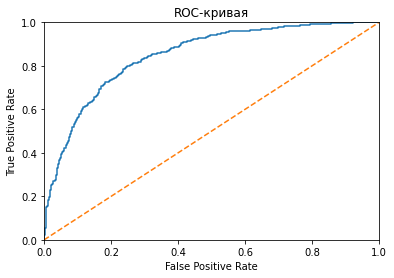

In [86]:
predicted_probalities = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

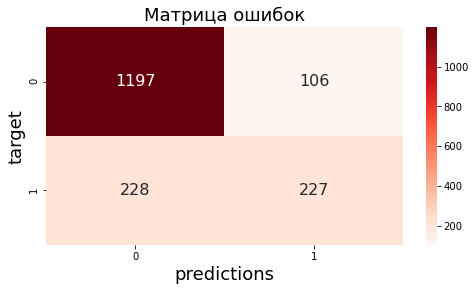

In [87]:
cm_cbc = confusion_matrix(target_test, predictions)
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

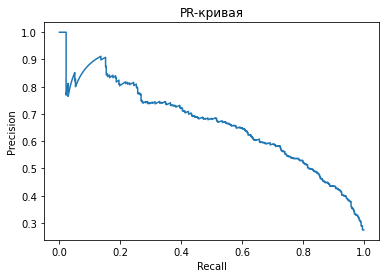

In [88]:
precision, recall, threshold = precision_recall_curve(target_test, y_pred_proba)
plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')

plt.show()


Исследуем важность признаков у лучшей модели.

,importance
feature,
TotalCharges,23.979620
dbp,22.789360
InternetService_Fiber optic,11.934309
MonthlyCharges,8.949690
PaymentMethod_Electronic check,3.662883
PaperlessBilling_Yes,2.909391
OnlineSecurity_Yes,2.840508
TechSupport_Yes,2.346667
StreamingTV_Yes,1.952405


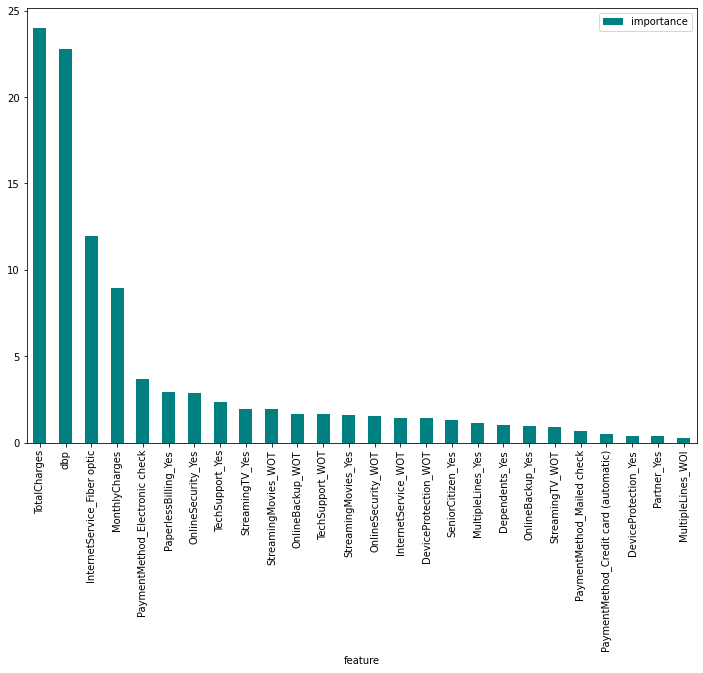

In [89]:
feature_names_numeric = numerics
feature_names_categorical = col_transformer.named_transformers_['ohe'].get_feature_names(categorical)
feature_names = feature_names_numeric + list(feature_names_categorical)

feature_importances = model.feature_importances_

fi_df = pd.DataFrame({'feature': feature_names,
                   'importance': feature_importances}) \
                    .sort_values('importance', ascending = False)

fi_df.set_index('feature', inplace=True)
display(fi_df.head(10))

fi_df.plot.bar(color = 'teal', figsize=(12, 8));

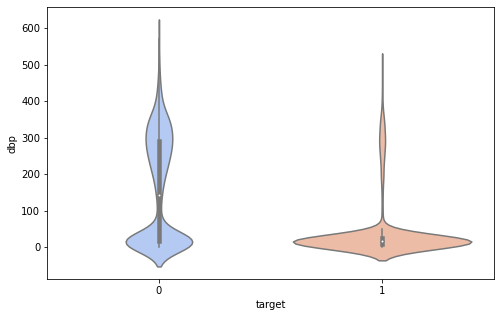


Корреляция Phik: 0.5
-----------------------------------------------------------------------------------------------



In [90]:
violentplot(data, 'dbp', 'target')

Самые весомые показатели для нашей модели - признак totalcharges и наш сгенерированный признак dbp (количество дней до оплаты следующего периода). Как мы можем видеть, на графике зависимости люди чаще всего расторгают договор с компанией за несколько дней до продления периода. Можно сделать вывод, что выдавать купоны на скидку нужно именно в данный момент - это может поднять интерес клиента.

## Вывод

Бустинг модель CatBoostClassifier очень хорошо показала себя на тестовых данных. По итогам предсказаний метрика AUC-ROC = 0.85.

Если обратиться к матрице ошибок, то можно увидеть, что наша модель чаще ошибается с 1 (предсказывает 0), нежели с 1 (предсказывает 0). С точки зрения бизнеса - это не особо хороший показатель, т.к. в нашем случае не так страшно получить ошибку первого рода, нежели второго. Итоги:

- 68% от общего количества тестовых данных - правильное предсказание класса 0,
- 13% - правильное предсказание класса 1,
- 6% - ложное предсказание класса 0, метка предсказания - 1,
- 13% - ложное предсказание класса 1 (модель пропускает человека, который планирует разорвать договор на оказание услуг).

Из работы модели выявили, что предлагать промокоды и специальные условия тем, кто планирует отказаться от услуг связи, следует за несколько дней до продления периода. 

Можно вывести показатели данной модели на более высокий уровень, увеличив временной промежуток. Стоит собрать как можно больше информации, возможно, сгенерировать её и поставить на обработку искуственные наблюдения.
